### Assignment 5 by Joan Plepi (matr: 3056655) and Agajan Torayev (matr: 3067341)

In [1]:
# http://pytorch.org/
# from os.path import exists
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
# cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
# accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
  
# # for PIL
# !pip install Pillow==4.1.1
# !pip install PIL
# !pip install image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import json

plt.ion()   # interactive mode

# for files from google drive
# from google.colab import drive
# drive.mount('/content/drive')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Imagenet Classes (Soccer Ball is 805)

In [2]:
imagenet_classes = json.load(open("imagenet_class_index.json"))
class_names = [imagenet_classes[str(i)][1] for i in range(len(imagenet_classes))]
print(class_names[805])

soccer_ball


### Load Data

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

### Helper Functions

In [4]:
# credits to https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                
                # all labels should be soccer ball labels
                labels = labels + 805
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            
            # all labels should be soccer ball labels
            labels = labels + 805
            
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

def get_acc(model, testloader):
    model.eval()
    model.to(device)

    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloaders['val']):
            
            # all labels should be soccer ball labels
            labels = labels + 805
            
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            probs, pred_labels = torch.max(outputs.data, 1)
            correct += (pred_labels == labels).sum().item()
            total += labels.size(0)

    return 100 * correct / total

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

### Visualize Data

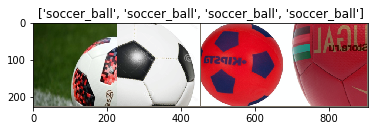

In [5]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x + 805] for x in classes])

### Resnet18

In [6]:
model_ft = models.resnet18(pretrained=True)
model_ft = model_ft.to(device)

### Visualization and accuracy before training

In [7]:
pre_acc = get_acc(model_ft, dataloaders['val'])

Accuracy of detecting soccer ball before training on validation set: 85.00%


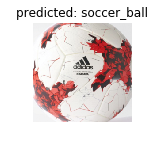

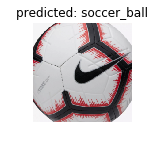

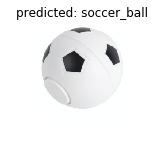

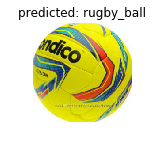

In [8]:
print("Accuracy of detecting soccer ball before training on validation set: {:.2f}%".format(pre_acc))
visualize_model(model_ft, num_images=4)

### Train the resnet

In [9]:
criterion = nn.CrossEntropyLoss()

# all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=1)

Epoch 0/0
----------
train Loss: 0.3903 Acc: 0.9400
val Loss: 0.0000 Acc: 1.0000

Training complete in 1m 22s
Best val Acc: 1.000000


### Visualization and accuracy after training

In [10]:
after_acc = get_acc(model_ft, dataloaders['val'])

Accuracy of detecting soccer ball after training on validation set: 100.00%


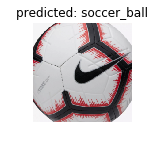

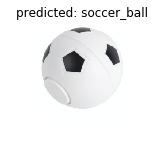

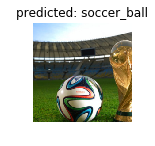

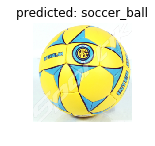

Exception ignored in: <function _DataLoaderIter.__del__ at 0x11d202b70>
Traceback (most recent call last):
  File "/Users/torayeff/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/Users/torayeff/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/Users/torayeff/anaconda3/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/Users/torayeff/anaconda3/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 167, in rebuild_storage_filename
    storage = cls._new_shared_filename(manager, handle, size)
RuntimeError: Interrupted system call at /Users/soumith/miniconda2/conda-bld/pytorch_1532624435833/work/torch/lib/libshm/core.cpp:99


In [11]:
print("Accuracy of detecting soccer ball after training on validation set: {:.2f}%".format(after_acc))
visualize_model(model_ft, num_images=4)

# Different implementation using another definition for FC layer (see below)

In [1]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
            
                    outputs = model(inputs) # here we are getting the sigmoid outputs
                    
                    # The NLLLoss needs two outputs. 
                    #outputs = torch.zeros(out.size()[0],2) 
                    #outputs[:, 0] = out[:, 0] # current one
                    #outputs[:, 1] = 1 - out[:,0] # 1-current one

                    loss = criterion(outputs, 1-labels.float()) # labels are zero but we need those as 1. 
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                        

                # statistics
                running_loss += loss.item() * inputs.size(0)
                # 0.7 is the probability threshhold for which we decide to call it a "soccer ball"
                running_corrects += torch.sum(torch.where(outputs.cpu() > 0.7, torch.ones(outputs.size()), torch.zeros(outputs.size())))
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# The new architecture for FC layer. 
layers = []
layers.append(nn.Linear(num_ftrs, int(num_ftrs/2)))
layers.append(nn.ReLU())
layers.append(nn.Linear(int(num_ftrs/2), 1))
layers.append(nn.Sigmoid())

model_ft.fc = nn.Sequential(*layers)
model_ft = model_ft.to(device)

# Binary cross entropy loss
criterion = nn.BCELoss()

# Again all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)